# 1. Dataset Preparation
First, we will load the required libaries and load the dataset using pandas dataframe.

In [3]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("creditcard.csv")
data["Time"] = data["Time"].apply(lambda x: x/3600%24)
data.head()

ModuleNotFoundError: No module named 'keras'

The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - class. Lets look at the distribution of target

In [4]:
vc = data["Class"].value_counts().to_frame().reset_index()
vc["percent"] = vc["Class"].apply(lambda x: round(100*float(x)/len(data), 2))
vc = vc.rename(columns = {"index": "Target", "Class": "Count"})
vc

NameError: name 'data' is not defined

One of the biggest challenges of this problem is that the target is highly imbalanced as only 0.17% cases are fraud transactions. But the advantage of the representation learning approach is that it is still able to handle such imbalance nature of the problems. We will look how. For our use-case, let's take only 1000 rows of non-fraud transactions

#  Consider only 1000 rows of non fraud cases

In [5]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data["Class"] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
Y = df["Class"].values

NameError: name 'data' is not defined

# 2. Visualize Fraud and NonFraud Transactions

Let's visualize the nature of fraud and non-fraud transactions using T-SNE. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

Every dot in the following represents a transaction. Non Fraud transactions are represented as green while fraud transactions are represented as red. The two axis are the components extracted by tsne.

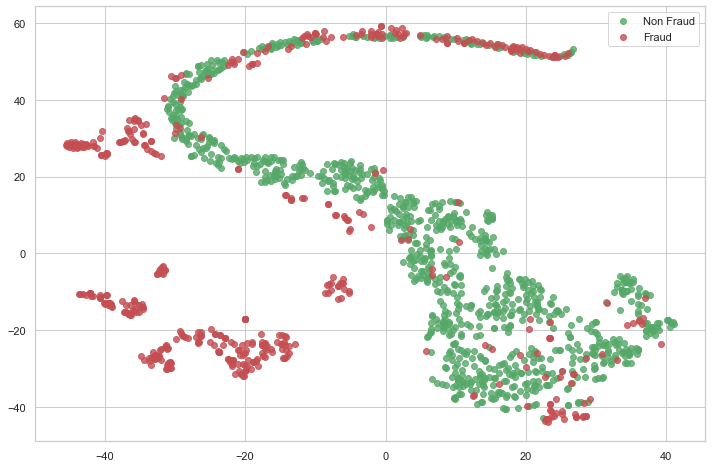

In [22]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
    plt.legend(loc="best")
    plt.savefig(name)
    plt.show()

tsne_plot(X, Y, "original.png")

From the above graph, we can observe that there are many non_fraud transactions which are very close to fraud transactions, thus are difficult to accurately classify from a model.

# 3. AutoEncoders to the rescue

What are AutoEncoders? - Autoencoders are a special type of neural network architectures in which the output is the same as the input. Autoencoders are trained in an unsupervised manner in order to learn the extremely low level representations of the input data. These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identiy function). These networks have a tight bottleneck of a few neurons in the middle, forcing them to create effective represnetations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.

We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimenstions ie the shape of non-fraud cases. We will use the keras package.

In [1]:
X.shape

NameError: name 'X' is not defined

In [23]:
## Input layer
input_layer = Input(shape = (X.shape[1],))

## Encoding part
encoded  = Dense(100, activation='tanh', activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation="relu")(encoded)

# Decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## Output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function

In [24]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adadelta', loss='mse')

Before training, lets peform min max scaling

In [26]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y ==0], x_scale[y == 1]

The beauty of this approach is that we do not need too many samples of data for learning the good representations. We will us eonly 2000 rows of non fraud cases to train the autoencoder. Additionally, we do not need to run this model for a large number of epochs.

Explanation: The choice of small samples from the original dataset is based on the intuition that one class characteristics (non fraud) will differ from that of the other (fraud). To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automatically distinguish the other class.

In [42]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
               batch_size=256, epochs = 20,
               shuffle = True, validation_split = 0.20)

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 0s 19us/step - loss: 0.1628 - val_loss: 0.1183
Epoch 2/20
1600/1600 [==============================] - 0s 21us/step - loss: 0.1771 - val_loss: 0.0994
Epoch 3/20
1600/1600 [==============================] - 0s 23us/step - loss: 0.1719 - val_loss: 0.1003
Epoch 4/20
1600/1600 [==============================] - 0s 21us/step - loss: 0.1728 - val_loss: 0.0986
Epoch 5/20
1600/1600 [==============================] - 0s 26us/step - loss: 0.1711 - val_loss: 0.1014
Epoch 6/20
1600/1600 [==============================] - 0s 31us/step - loss: 0.1739 - val_loss: 0.0973
Epoch 7/20
1600/1600 [==============================] - 0s 27us/step - loss: 0.1709 - val_loss: 0.0942
Epoch 8/20
1600/1600 [==============================] - 0s 27us/step - loss: 0.1701 - val_loss: 0.0982
Epoch 9/20
1600/1600 [==============================] - 0s 23us/step - loss: 0.1707 - val_loss: 0.1007
Epoch 10/20
1600/1600 [===

# 4. Obtain the Latent Representations

Now, the model is trained. We are interested in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequantial layers and we will only add the trained weights until the third layer, were the latent representation exists

In [43]:
hidden_representation = Sequential()
for i in range(3):
    hidden_representation.add(autoencoder.layers[i])

Generate the hidden representations of two classes: non-fraud and fraud by predicting the raw inputs using the above model

In [44]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

# 5. Visualize the latent representations: Fraud vs Non Fraud

Now we will create a training dataset using the latent representations oobtained and lets visualize the nature of fraud vs non-fraud cases.

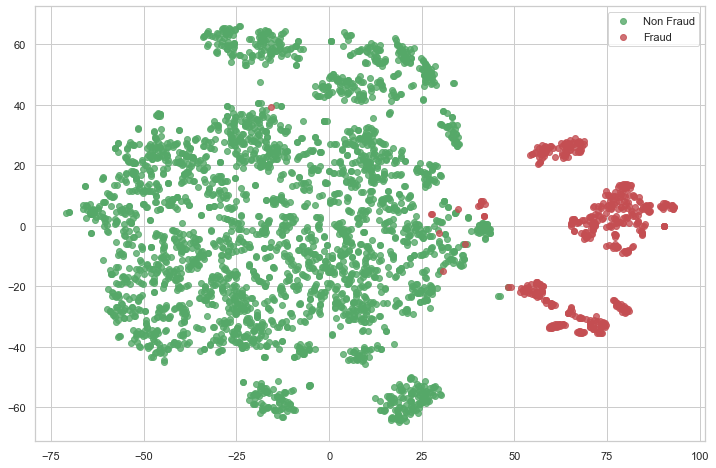

In [57]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.jpg")

What a perfect graph, we can observe that now fraud and non-fraud transactions are pretty visible and are linearly separable. Now we dont need any complex model to classify this, even the simpler models can be used to predict.



In [58]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.jpg'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


Now, we can just train a simple linear classifier on the dataset

In [59]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print("Classification Report:")
print(classification_report(val_y, pred_y))
print("")
print("Accuracy Score:", accuracy_score(val_y, pred_y))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       761
         1.0       1.00      0.89      0.94       112

    accuracy                           0.99       873
   macro avg       0.99      0.95      0.97       873
weighted avg       0.99      0.99      0.99       873


Accuracy Score: 0.9862542955326461


In [54]:
print(rep_x.shape)
print(rep_y.shape)

(3492, 50)
(3050,)


In [56]:
norm_hid_rep.shape

(3000, 50)